In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from colormap import Color
import datetime
import time
import mplleaflet
import salem
import motionless
from salem import get_demo_file, DataLevels, GoogleVisibleMap, Map

%matplotlib inline

#logging
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.debug('Test Debug')

In [2]:
# read cumtd files and make a panda dataframe from the files
# calendar_dates.txt
calendar_dates = pd.read_csv('cumtd/calendar_dates.txt')
# routes
routes = pd.read_csv('cumtd/routes.txt')
# shapes
shapes = pd.read_csv('cumtd/shapes.txt')
# stop_times
stop_times = pd.read_csv('cumtd/stop_times.txt')
# stops
stops = pd.read_csv('cumtd/stops.txt')
# trips
trips = pd.read_csv('cumtd/trips.txt')


In [9]:
# convert arrival and departure time into millisecond
def convertToSecond(col):
    arr_val = col
    if(int(arr_val[0:2])>=24):
        arr_val='{0:02d}'.format(int(arr_val[0:2])-24)+arr_val[2:len(arr_val)]
    x = time.strptime(arr_val, "%H:%M:%S")
    second = datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
    return second

stop_times['arrival_time_ms'] = stop_times['arrival_time']\
    .apply(lambda col: convertToSecond(col))    
stop_times['departure_time_ms'] = stop_times['departure_time']\
    .apply(lambda col: convertToSecond(col))


In [10]:
# calculate travel time and add travel time into trips data frame
def getTravelTime(stop_times,trip_id):
    # filter stop_times by trip_id
    obs_stops = stop_times[stop_times['trip_id']==trip_id]
    # get minimum seq and maximum sequence of trips
    min_seq = obs_stops['stop_sequence'].min()
    max_seq = obs_stops['stop_sequence'].max()
    max_time = obs_stops[obs_stops['stop_sequence']==max_seq]['arrival_time_ms'].values[0]
    min_time = obs_stops[obs_stops['stop_sequence']==min_seq]['departure_time_ms'].values[0]
    travel_time = 0
    max_bound = convertToSecond('23:59:59')
    if min_time < max_time:
        travel_time = max_time - min_time
    else:
        travel_time = max_bound - min_time + max_time
    #print(max_seq)
    # calculate travel time
    #print(obs_stops[obs_stops['stop_sequence']==max_seq]['arrival_time_ms'].values)
    #print(obs_stops[obs_stops['stop_sequence']==min_seq]['departure_time_ms'].values)
        
    #print(travel_time)
    return travel_time

trips['travel_time'] = trips.trip_id.apply(lambda col:getTravelTime(stop_times,col))

In [11]:
# get stops frequency
def getFrequency(stop_times,trip_id):
    # filter stop_times by trip_id
    obs_stops = stop_times[stop_times['trip_id']==trip_id]
    # count the stop frequency for trips
    stop_frequency = obs_stops.groupby('trip_id')['trip_id'].count().values[0]
#    print(stop_frequency)
    return stop_frequency

trips['stop_frequency'] = trips.trip_id.apply(lambda col:getFrequency(stop_times,col))

In [12]:
# get trips travel distance
def getTravelDistance(shapes,shape_id):
    # filter stop_times by trip_id
    obs_shape = shapes[shapes['shape_id']==shape_id]
    # count the stop frequency for trips
    travel_distance = obs_shape.groupby('shape_id')['shape_dist_traveled'].sum().values[0]
#    print(stop_frequency)
    return travel_distance

trips['travel_distance'] = trips.shape_id.apply(lambda col:getTravelDistance(shapes,col))    

## CUMTD (All Route)

We plotted all the routes based on the shapes data. In this visualization, the color for each route matches the name of the route. Some routes have the same name but are operated in different times. In this case, we combined them into single color in order to show the shape of the whole Champaign-Urbana MTD routes.


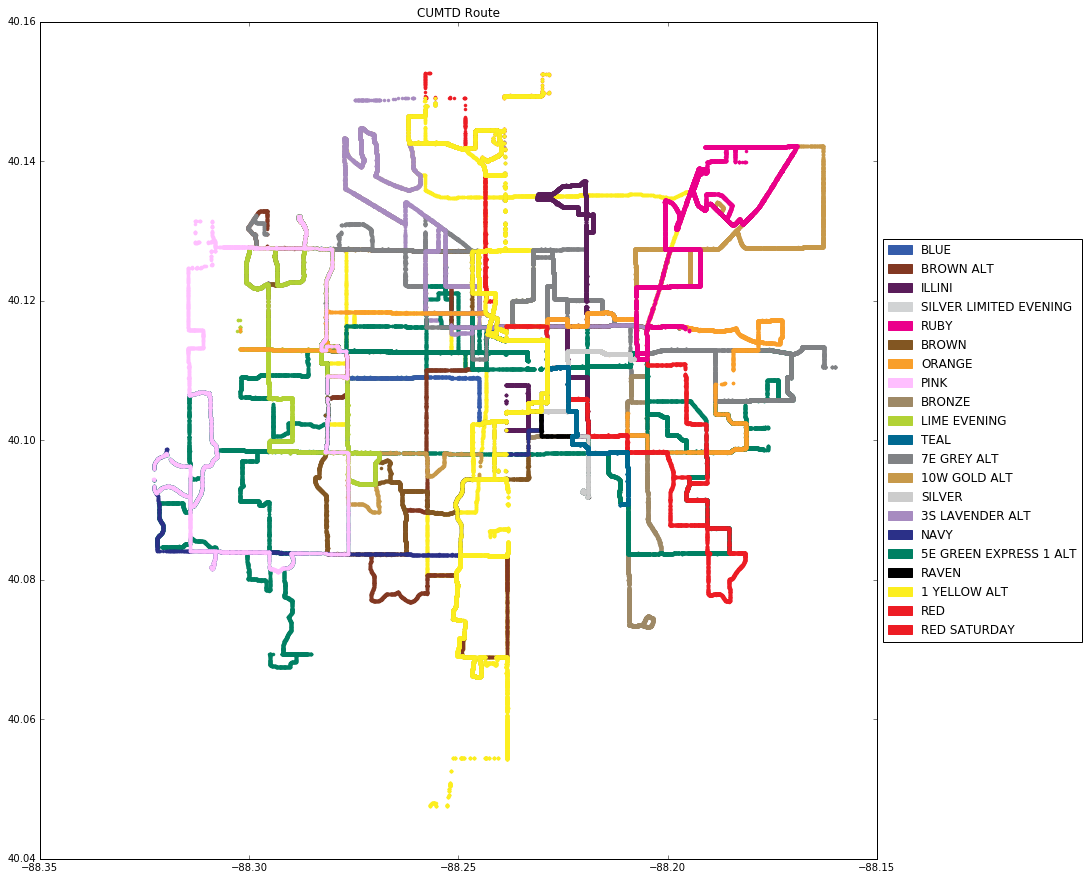

In [147]:
def draw_plot_lambda(routes,shapes,route_id,shape_id,ax,color_legends = {}):
#    obs_route = routes[routes['xroute_id']==route_id]
    obs_color = routes[routes['xroute_id']==route_id]['route_color'].values[0]
    obs_rgb=Color('#'+obs_color)
    # record colors, because one colors can be used by many routes
    if obs_color not in color_legends:
        color_legends[obs_color] = []
    color_legends[obs_color].append(route_id)
    obs_shape = shapes[shapes['shape_id']==shape_id]
    ax.plot(obs_shape['shape_pt_lon'],obs_shape['shape_pt_lat'],'.',color=obs_rgb.hex)
    
def filterTrips(x,trips):
#    print(x.name)
    print(trips[(trips['route_id']==x.name)&(trips['stop_frequency']==x.stop_frequency)])
    return trips[(trips['route_id']==x.name)&(trips['stop_frequency']==x.stop_frequency)]
    
def draw_plot(routes,trips):
    color_legends = {}
    sample_fig = plt.figure(figsize=(15,15));
    ax = plt.subplot();
    # get the maximum stop_frequency from trips to get
    # the maximum trips, saving time instead of ploting all the trips    
    trips_max = trips.groupby('route_id')['stop_frequency'].max()
    
    
    obs_shape_arr = []
    for trip_idx,trip_val in trips_max.iteritems():
        test_trips = trips[(trips['route_id']==trip_idx)&(trips['stop_frequency']==trip_val)]
#        print(test_trips.iloc[0]['shape_id'])
        if test_trips.shape[0] > 0 :
            obs_shape_arr.append((trip_idx,test_trips.iloc[0]['shape_id']))            
#    print(obs_shape_arr)
    #trips.apply(lambda row: draw_plot_lambda(routes,row['route_id'],row['shape_id'],ax),axis=1)
    #obs_shape_arr.apply(lambda row: draw_plot_lambda(routes,row['route_id'],row['shape_id'],ax),axis=1)
    [draw_plot_lambda(routes,shapes,x,y,ax,color_legends) for x,y in obs_shape_arr]
    #mplleaflet.display()
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    #ax.xaxis.set_ticks([])
    #ax.yaxis.set_ticks([])
    
    return sample_fig,ax,color_legends

    """
    for trip_idx,obs_trips in trips.iterrows():
        obs_color = routes[routes['xroute_id']==obs_trips['route_id']]['route_color'].values[0]
        obs_rgb=Color('#'+obs_color)
        obs_shape = shapes[shapes['shape_id']==obs_trips.shape_id]
        ax.plot(obs_shape['shape_pt_lat'],obs_shape['shape_pt_lon'],'.',color=obs_rgb.hex)
    """     

# plot all the routes
figure,ax,color_legends = draw_plot(routes,trips)
# draw the legends
patch_array = []
route_colors = {}
for key,val in color_legends.items():
    patch_array.append(mpl.patches.Patch(color='#'+key,label=val[0]))
    for x in val:
        route_colors[x] = key

ax.legend(handles=patch_array, loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_title('CUMTD Route')
#mplleaflet.display()
plt.show()

# 1st Visualization:
In our first visualization we want to visualize which route has the most frequent buses over the weekly schedule between work hours range (08:00 - 17:00)

In order to show only the most frequent routes, our first step is to get the 10 most frequent routes from the trips data. Then we plotted the 10 routes based on the shapes data. We also added legends to the graph, which are ordered by frequencies from highest to lowest, so that users can easily recognize which route is the most frequent one. To reduce confusion, we assigned the colors to the routes according to the route names, for example, we assigned yellow to Yellow Hopper. 

Because we defined a series of functions before plotting the graph, our visualization is reproducible. We can easily visualize another dataset with same structures using this approach. In addition, our visualization is easy to understand. Users can get clear information from the graph. However, the procedure of our approach is complex and data processing took us a lot of time. Moreover, the visualization is not informative enough. We could add an affiliated histogram to the graph showing the number of frequencies.


In [15]:
# get mean time and travel_distance for each route
def meanTimeRoute(col,trips):
#    print(row)
    obs_trip = trips[trips['route_id']==col]
    mean_time = obs_trip.groupby('route_id')['travel_time'].mean()
#    print(mean_time.shape[0])
    if mean_time.shape[0] > 0:
        mean_time = mean_time[0]
    else:
        mean_time = 0
    return mean_time

def meanDistRoute(col,trips):
#    print(row)
    obs_trip = trips[trips['route_id']==col]
    mean_dist = obs_trip.groupby('route_id')['travel_distance'].mean()
    if mean_dist.shape[0] > 0 :
        mean_dist = mean_dist[0]
    else:
        mean_dist = 0
    return mean_dist

def meanStopFreq(col,trips):
    obs_trip = trips[trips['route_id']==col]
    mean_stop = obs_trip.groupby('route_id')['stop_frequency'].mean()
    if mean_stop.shape[0] > 0 :
        mean_stop = mean_stop[0]
    else:
        mean_stop = 0
    return mean_stop    
    
routes['mean_time'] = routes.xroute_id.apply(lambda col: meanTimeRoute(col,trips))
routes['mean_dist'] = routes.xroute_id.apply(lambda col: meanDistRoute(col,trips))
routes['mean_stop'] = routes.xroute_id.apply(lambda col: meanStopFreq(col,trips))

In [16]:
# filter from stop_time arrival time that has 08:00 until 17:00 value
low_time = convertToSecond('08:00:00')
high_time = convertToSecond('17:00:00')
stop_mask = (stop_times['arrival_time_ms']>=low_time) & (stop_times['arrival_time_ms']<=high_time)
stop_obs = stop_times[stop_mask]


In [17]:
# filter trip_id based on the stop_obs and collect the frequency based on route
def filterTripsById(trips,trip_id):
    return(trips[trips['trip_id'].isin(trip_id)])

trips_obs = filterTripsById(trips,stop_obs['trip_id'].unique())
#trips_obs = stop_obs['trip_id'].unique().map(lambda x:filterTripsById(trips,x))

In [18]:
# get the total trips by route_id
# and order the total
top_10_route = trips_obs.groupby('route_id')['route_id'].count().sort_values(ascending=False)
color_count = 0
top_10_color_hash = {}
top_10_color_idx = []
top_10_color_set = []
for idx,val in top_10_route.iteritems():
    if route_colors[idx] not in top_10_color_hash:
        top_10_color_hash[route_colors[idx]] = (idx,val,route_colors[idx])
        top_10_color_idx.append(idx)
        top_10_color_set.append((idx,val,route_colors[idx]))
        color_count+=1
    if color_count >= 10:
        break;        

In [20]:
# filter trip by route
def filterTripsByRoute(trips,route_id):
    return(trips[trips['route_id'].isin(route_id)])

#trips_top_10 = filterTripsByRoute(trips_obs,top_10_route.index)
trips_top_10 = filterTripsByRoute(trips_obs,top_10_color_idx)

/Volumes/HD-500GB/Users/nikolausn/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


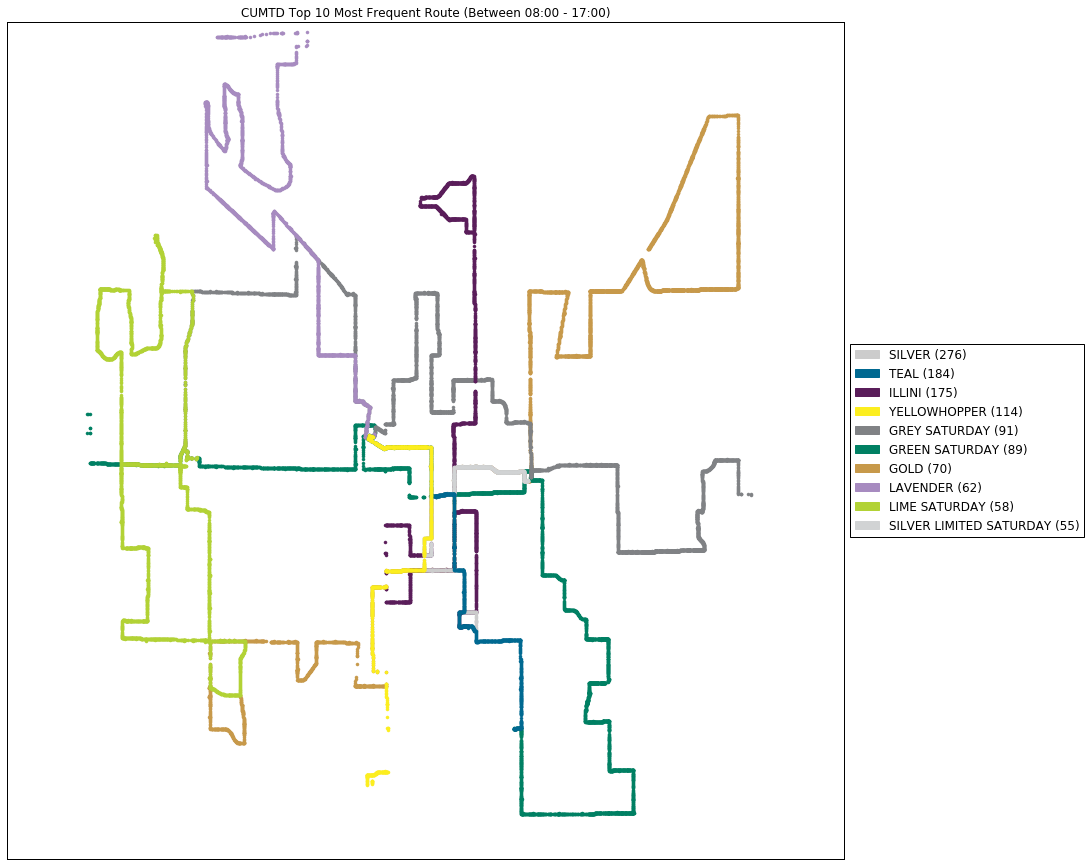

In [21]:
trips_top_10['stop_frequency'] = trips_top_10.trip_id.apply(lambda col:getFrequency(stop_times,col))
figure,ax,color_legends_top10 = draw_plot(routes,trips_top_10)
# draw the legends
patch_array = []
for val in top_10_color_set:
    patch_array.append(mpl.patches.Patch(color='#'+val[2],label='{} ({})'.format(val[0],val[1])))

ax.legend(handles=patch_array, loc='center left', bbox_to_anchor=(1, 0.5)) 

ax.set_title('CUMTD Top 10 Most Frequent Route (Between 08:00 - 17:00)')
#mplleaflet.display()
plt.show()

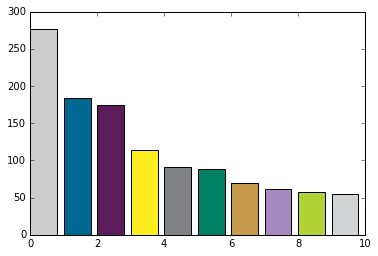

In [22]:
i = 0
patch_array = []
for val in top_10_color_set:
    plt.bar(i,val[1],color='#'+val[2])
    i+=1


## 2. Stops Observation
In this visualization, we observe Stops density, which stops has most frequent buses coming
for the time schedule range

## 2.a Stop density visualization, visualize Density of a stop based on CUMTD schedule
We plotted the stops on a static google map to show the stop densities. When people are looking at the visualization, they can easily figure out which area has the highest stop density. In our graph, it is the center of campus. In our visualization, we counted the buses over 7 days, which makes the numbers of stop density to be very high. We could add some annotations to the graph to explain this if necessary.


In [27]:
## Stops observation
# get the top 10 stop density as our observation data
topConstant = 5
stop_all_density = stop_times.groupby('stop_id')['stop_id'].count()
stop_top_10_density = stop_times.groupby('stop_id')['stop_id'].count().sort_values(ascending=False)[0:topConstant]
stop_top_10_obs = stop_times[stop_times['stop_id'].isin(list(stop_top_10_density.index))]

In [29]:
#plt.figure(figsize=(15,15));
# copy the observation stops and match it with frequency
obs_stops = stops.copy()
stop_times['arrival_time_ms'] = stop_times['arrival_time']\
    .apply(lambda col: convertToSecond(col))
obs_stops['frequency'] = obs_stops['stop_id'].apply(lambda col: stop_all_density[col])
#plt.hexbin(obs_stops['stop_lon'],obs_stops['stop_lat'],obs_stops['frequency'])

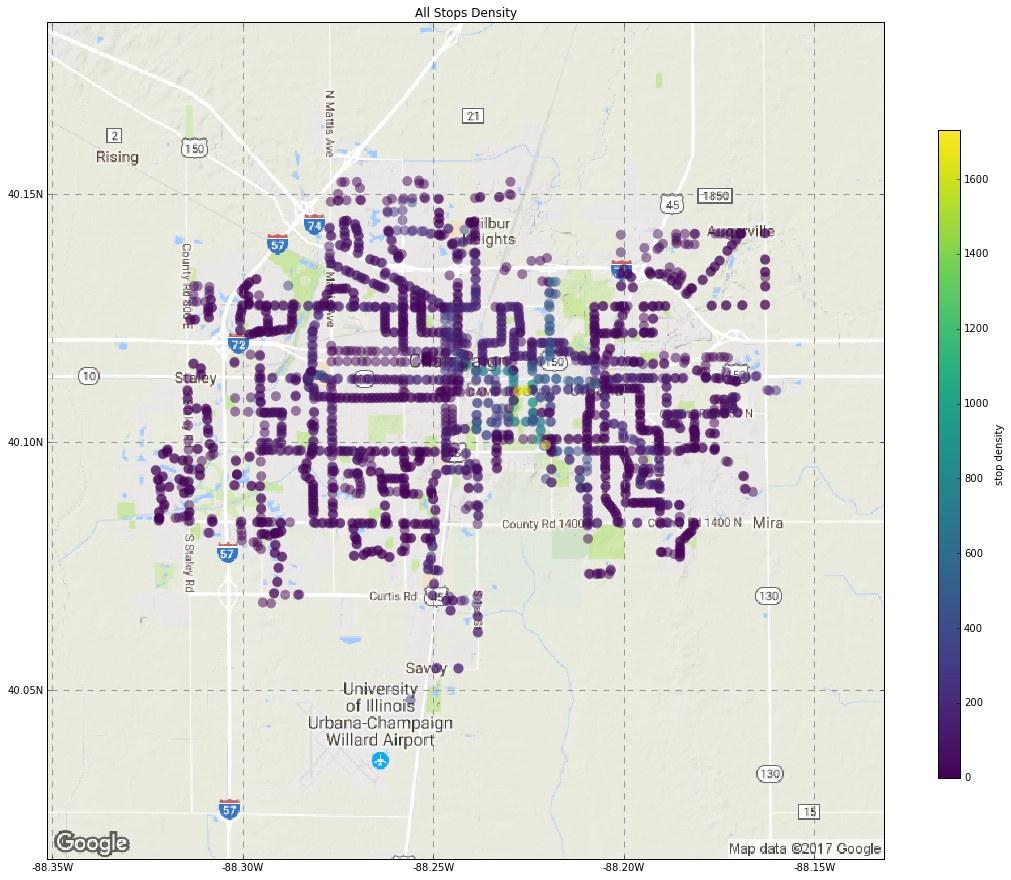

In [45]:
# Plot stops according to its frequency using color map
# plt.plot(stops['stop_lon'], stops['stop_lat'], '.') # Draw blue line
fig=plt.figure(figsize=(15,15))
#plt.axis([0,400,0,400])
ax=fig.add_subplot(1,1,1)
min_freq = obs_stops.frequency.min()
max_freq = obs_stops.frequency.max()
min_lon = obs_stops['stop_lon'].min()
max_lon = obs_stops['stop_lon'].max()
min_lat = obs_stops['stop_lat'].min()
max_lat = obs_stops['stop_lat'].max()
g = GoogleVisibleMap(x=[min_lon, max_lon], y=[min_lat, max_lat],
                     maptype='terrain')  # satellitetry out also: 'terrain'


# the google static image is a standard rgb image
ggl_img = g.get_vardata()
#ax.imshow(ggl_img)
# make a map of the same size as the image (no country borders)
sm = Map(g.grid, factor=1, countries=False)
sm.set_rgb(ggl_img)  # add the background rgb image
sm.visualize(ax=ax)  # plot it
x, y = sm.grid.transform(obs_stops['stop_lon'], obs_stops['stop_lat'])
scatt = ax.scatter(x,y,c=obs_stops.frequency,cmap=plt.get_cmap('viridis'),vmin=0,vmax=max_freq,s=100,alpha=0.5,edgecolors='none')

norm = mpl.colors.Normalize(vmin=0, vmax=max_freq)
cmap = plt.get_cmap('viridis')
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional')
cb.set_label('stop density')
ax.set_title('All Stops Density')

plt.show()

## 2.b. Most frequent stop according to statistics
Visualization above displays all stops with their frequency, now we interested in displaying the most frequent route only by filtering the stops that has frequency above the (mean + 1 standard deviation)

The method we used for this visualization is basically the same as we used for the previous one, but we only care about the densities of the most frequent stops. In this graph, we could find many points outside the campus center, the high-density area we noticed from previous visualization. By visualizing only those stops we care about, this graph gives us a clearer picture of how densities of those stops distributed geographically. 

We initially designed the map to be dynamic. Users could zoom it in and out to see the points in different ways. We then changed it to the static one because the instruction suggests making the visualizations in this part to be static. However, visualizing it in a dynamic way could be better.


(array([  2.14100000e+03,   2.31000000e+02,   7.20000000e+01,
          1.00000000e+01,   2.50000000e+01,   9.00000000e+00,
          2.00000000e+00,   4.00000000e+00,   1.00000000e+00,
          5.00000000e+00]),
 array([  1.00000000e+00,   1.74100000e+02,   3.47200000e+02,
          5.20300000e+02,   6.93400000e+02,   8.66500000e+02,
          1.03960000e+03,   1.21270000e+03,   1.38580000e+03,
          1.55890000e+03,   1.73200000e+03]),
 <a list of 10 Patch objects>)

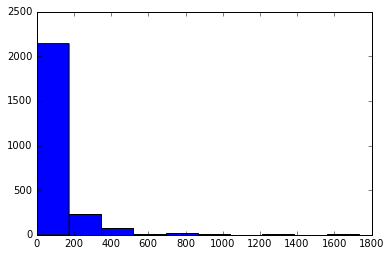

In [80]:
plt.hist(obs_stops.frequency)

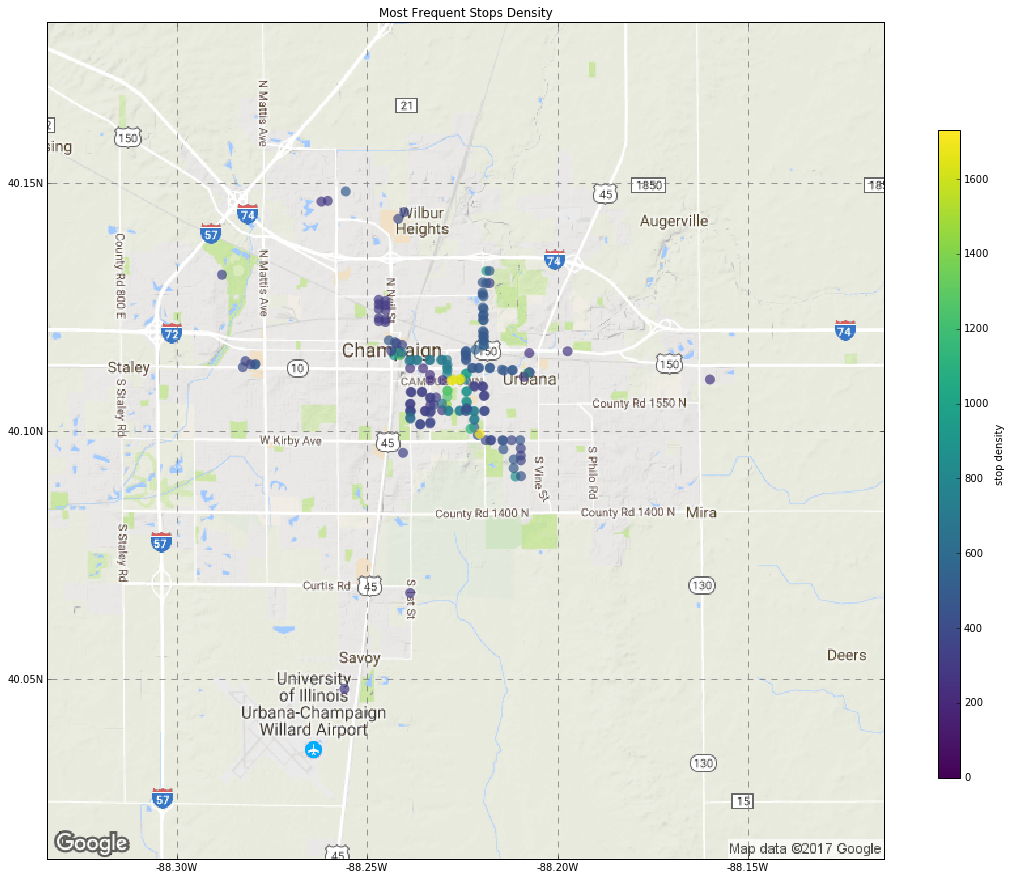

In [47]:
# filter out obs_stops that less than the frequency mean to 
# get frequent stops above all
obs_stops_frequent = obs_stops[obs_stops.frequency>(obs_stops.frequency.mean()+obs_stops.frequency.std())]

# Plot stops according to its frequency using color map
fig=plt.figure(figsize=(15,15))
#plt.axis([0,400,0,400])
ax=fig.add_subplot(1,1,1)
min_freq = obs_stops.frequency.min()
max_freq = obs_stops.frequency.max()
min_lon = obs_stops_frequent['stop_lon'].min()
max_lon = obs_stops_frequent['stop_lon'].max()
min_lat = obs_stops_frequent['stop_lat'].min()
max_lat = obs_stops_frequent['stop_lat'].max()
g = GoogleVisibleMap(x=[min_lon, max_lon], y=[min_lat, max_lat],
                     maptype='terrain')  # satellitetry out also: 'terrain'

# the google static image is a standard rgb image
ggl_img = g.get_vardata()
#ax.imshow(ggl_img)
# make a map of the same size as the image (no country borders)
sm = Map(g.grid, factor=1, countries=False)
sm.set_rgb(ggl_img)  # add the background rgb image
sm.visualize(ax=ax)  # plot it
x, y = sm.grid.transform(obs_stops_frequent['stop_lon'], obs_stops_frequent['stop_lat'])
scatt = ax.scatter(x,y,c=obs_stops_frequent.frequency,cmap=plt.get_cmap('viridis'),vmin=min_freq,vmax=max_freq,s=100,alpha=0.7,edgecolors='none')

# make it nice
norm = mpl.colors.Normalize(vmin=0, vmax=max_freq)
cmap = plt.get_cmap('viridis')
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional')
cb.set_label('stop density')
ax.set_title('Most Frequent Stops Density')


plt.show()

## 2.c Frequency of Bus coming to a stop over period of time (bining)
Besides stop density, we want to give visualization about the bus frequency that stop over the top 5 most frequent stops over time (time bining)

We binned the arrival times into 30 minutes’ bins, so there are 48 time bins for a 24 hours’ length. We visualized the frequencies using stack bar chart. The strength of this visualization is its comparability. We can compare the frequencies both over time and across different stops. To improve this visualization, we could make it dynamic and interactive so that people can choose to see one or several stops instead of looking at the whole five stops at the same time.


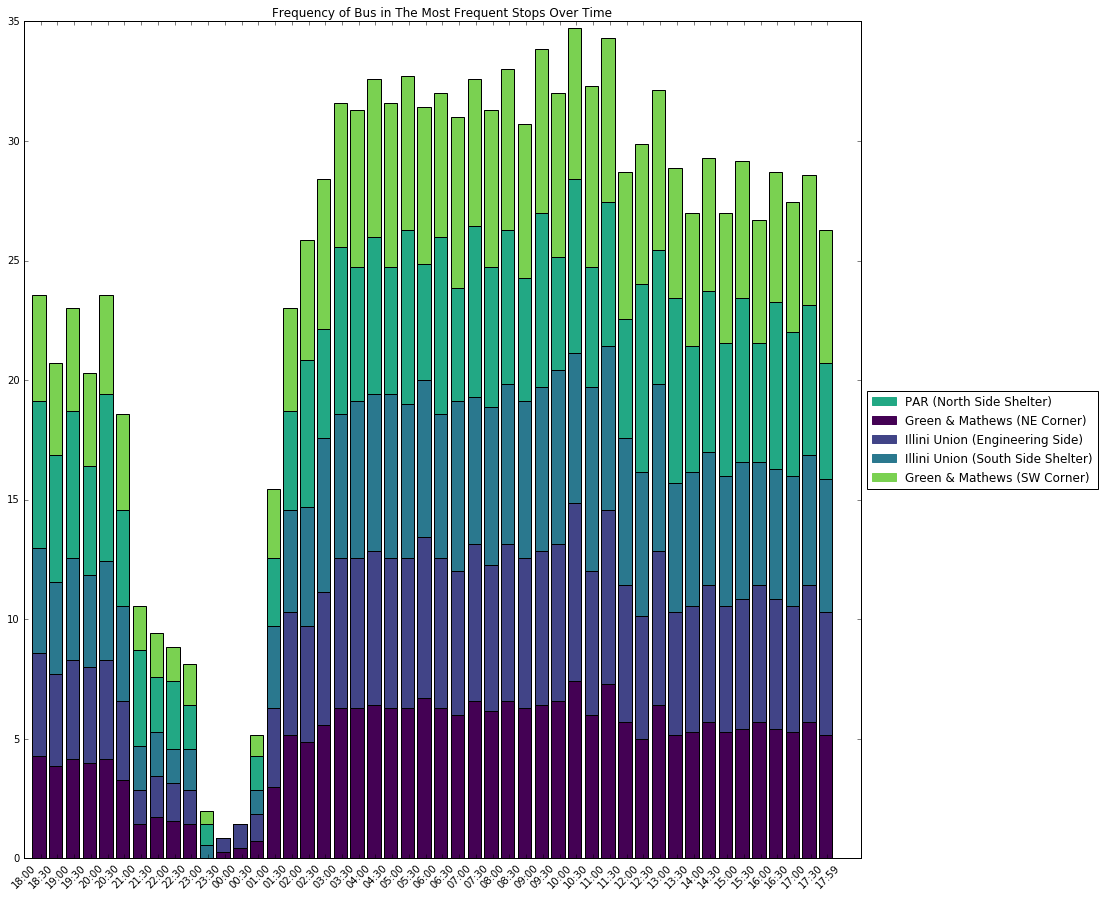

In [186]:
# bin the arrival time for every 30 minutes bin
binConstant = convertToSecond('00:30:00')
#low_time = stop_top_10_obs.arrival_time_ms.min()
#high_time = stop_top_10_obs.arrival_time_ms.max()
low_time = convertToSecond('00:00:00')
high_time = convertToSecond('23:59:59')
binNum = (high_time-low_time)/binConstant
# go through all the stop id and make bining for every 30 minutes
stop_top_10_name = stop_top_10_obs.stop_id.unique()

# to bin we need to make range between low_time, high_time and binConstant step
#bin_steps = np.linspace(low_time,high_time,binNum+1)
bin_steps = np.arange(low_time,high_time,binConstant)
bin_steps = np.append(bin_steps,high_time)

#print(bin_steps)

stop_bin_arr = []
x_labels = []
for i in range(len(bin_steps)-1):
#    print(i)
    bin_obs = stop_top_10_obs[(stop_top_10_obs['arrival_time_ms']>=bin_steps[i])&(stop_top_10_obs['arrival_time_ms']<bin_steps[i+1])]    
    stop_bin_arr.append(bin_obs.groupby('stop_id')['stop_id'].count())
    # calculate label
    x_labels.append(datetime.datetime.fromtimestamp(bin_steps[i]).strftime('%H:%M'))

x_labels.append(datetime.datetime.fromtimestamp(bin_steps[i+1]).strftime('%H:%M'))    
#print(x_labels)
    
# convert this back into stop id keys data
stop_time_series = {}
for name in stop_top_10_name:
    stop_time_series[name] = []
    
for stop_bin in stop_bin_arr:
    for name in stop_top_10_name:
        if name in stop_bin.index:
            stop_time_series[name].append(stop_bin[name])
        else:
            stop_time_series[name].append(0)

stop_full_name = [stops[stops.stop_id==x]['stop_name'].values[0] for x in stop_top_10_name]
            
# plot the stop_bin_arr using line plot in time series window

# define colors
norm = mpl.colors.Normalize(vmin=0,vmax=len(stop_time_series.keys()))
colorArr = {}
color='viridis'
# define color map for all categories
cm = plt.get_cmap(color)
i = 0
for key in stop_time_series.keys():
    color = cm(norm(i))
    colorArr[key] = color
    i+=1

sample_fig = plt.figure(figsize=(15,15));
ax = plt.subplot();
prev = np.zeros(len(stop_time_series[stop]))
for stop in stop_time_series.keys():    
    #ax.plot(list(range(0,len(stop_time_series[stop]))),stop_time_series[stop],'-')
    # because this is weekly schedule, we divide it by 7 (days for a week)
    #stop_plot = np.divide(np.array(stop_time_series[stop]),7)
    stop_plot = np.array(stop_time_series[stop])/7
    plot_loc = np.array(range(0,len(stop_time_series[stop])))+0.5
    ax.bar(plot_loc.tolist(),stop_plot.tolist(),color = colorArr[stop],bottom=prev.tolist())
    prev = stop_plot + prev
#print(x_labels)        
xticks = plt.xticks(range(len(stop_time_series[stop])+1),x_labels,rotation=45)


# draw the legends
patch_array = []
for i in range(len(stop_top_10_name)):
    patch_array.append(mpl.patches.Patch(color=colorArr[stop_top_10_name[i]],label='{}'.format(stop_full_name[i])))

leg = ax.legend(handles=patch_array, loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_title('Frequency of Bus in The Most Frequent Stops Over Time')
#ax.set_xticks(range(len(stop_time_series[stop])),x_labels)

## 3. Travel Time vs Stop Frequency and Travel Distance
In this plot, we try to give a trend plot that compares between Travel Time vs Stop Frequency and Travel Distance

The first graph compares the stop frequency with travel time, and the second one compares the travel distance with travel time. These two graphs are simple but useful. They show they trends and relationships between two factors very clearly. This visualization is good for looking at the routes as whole, but not good for looking at them separately. Although we assigned the routes with different colors, it is still hard to recognize the points and trend for a single route. To fix this problem, we can make it dynamic.


In [126]:
#plt.figure(figsize=(15,15));
#plt.hist((trips['travel_time']/60))

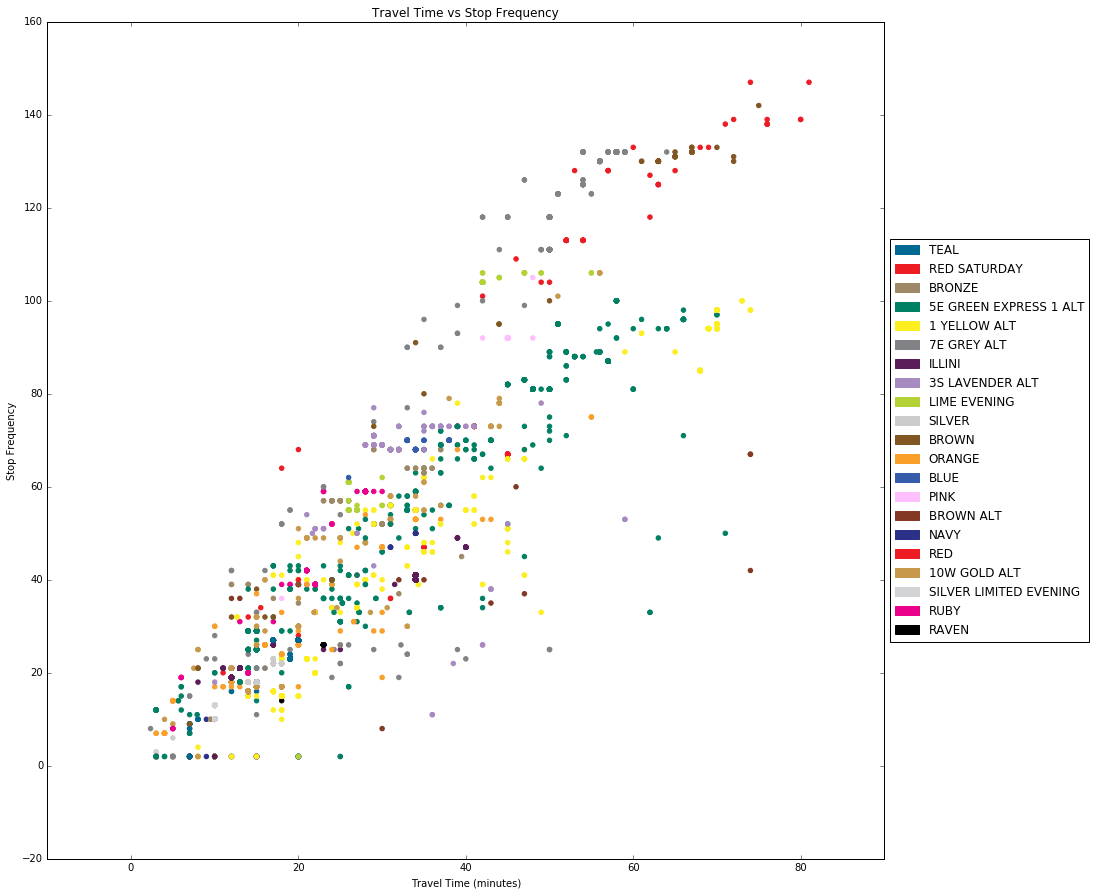

In [168]:
fig = plt.figure(figsize=(15,15));
ax = fig.add_subplot(1,1,1)

trips_colors = trips['route_id'].apply(lambda col: '#'+route_colors[col])

ax.scatter((trips['travel_time']/60),trips['stop_frequency'],color=trips_colors)
ax.set_xlabel('Travel Time (minutes)')
ax.set_ylabel('Stop Frequency')
ax.set_title('Travel Time vs Stop Frequency')

trace_color = {}
patch_array = []
for val in trips_colors:
    val = val[1:len(val)]
    if val not in trace_color:        
        patch_array.append(mpl.patches.Patch(color='#'+val,label=color_legends[val][0]))
        trace_color[val] = True

leg = ax.legend(handles=patch_array, loc='center left', bbox_to_anchor=(1, 0.5))

In [136]:
# histogram of travel_distance
#plt.figure(figsize=(15,15));
#plt.hist((trips['travel_distance']))

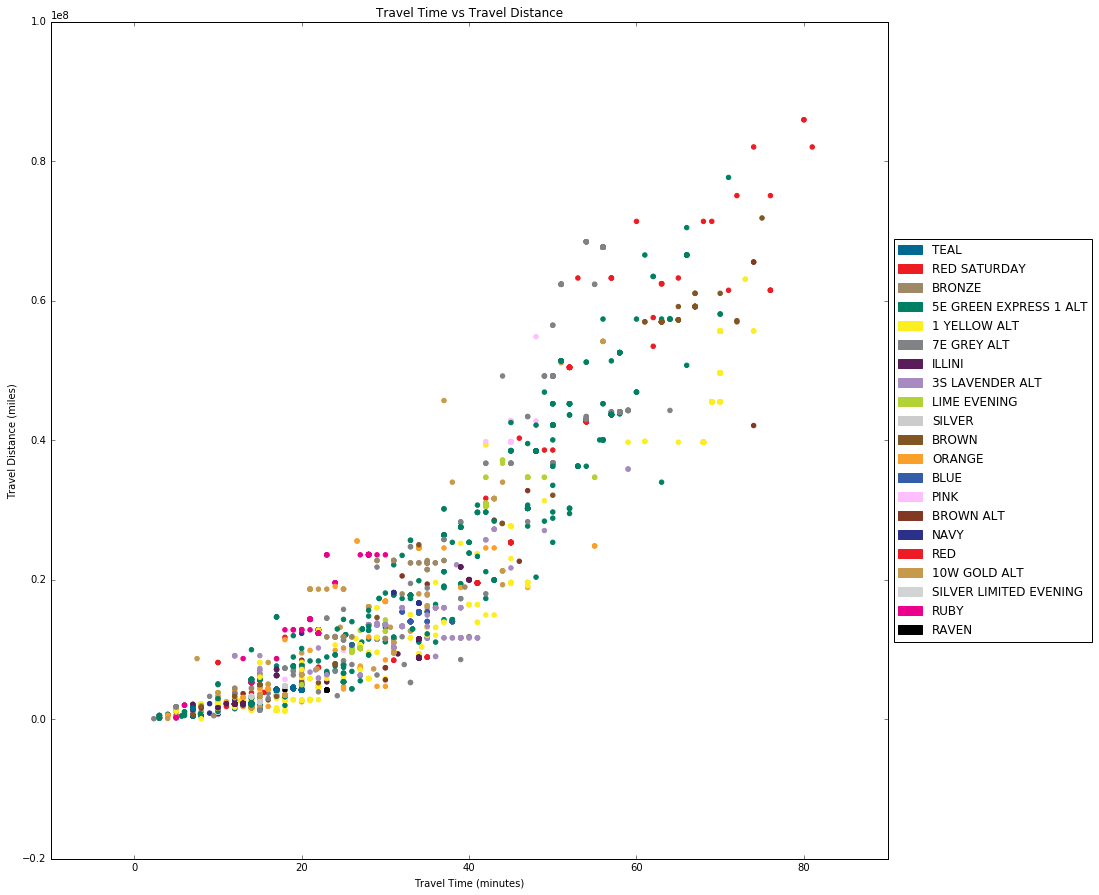

In [167]:
# relation between travel_time and travel_distance
fig = plt.figure(figsize=(15,15));
ax = fig.add_subplot(1,1,1)

trips_colors = trips['route_id'].apply(lambda col: '#'+route_colors[col])
ax.scatter((trips['travel_time']/60),trips['travel_distance'],color=trips_colors)
ax.set_xlabel('Travel Time (minutes)')
ax.set_ylabel('Travel Distance (miles)')
ax.set_title('Travel Time vs Travel Distance')

# Add Legend
trace_color = {}
patch_array = []
for val in trips_colors:
    val = val[1:len(val)]
    if val not in trace_color:        
        patch_array.append(mpl.patches.Patch(color='#'+val,label=color_legends[val][0]))
        trace_color[val] = True

leg = ax.legend(handles=patch_array, loc='center left', bbox_to_anchor=(1, 0.5))

# FINISH until here